In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.model_selection import train_test_split


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline


In [2]:
df = pd.read_csv('Twitter_Data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [3]:
# Any missing data?
df.isnull().sum()
df.dropna(axis=0, inplace=True)

In [4]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


Visualization

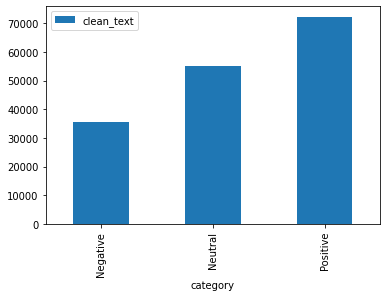

In [5]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

Data Cleaning

In [6]:

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *


def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [10]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))

In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

Training and Testing Data



In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print('Number of tweets in the total set : {}'.format(len(X)))
print('Number of tweets in the training set : {}'.format(len(X_train)))
print('Number of tweets in the testing set : {}'.format(len(X_test)))


Number of tweets in the total set : 162969
Number of tweets in the training set : 130375
Number of tweets in the testing set : 32594


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

MLM

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  42    1  307   66 1726 1119   40 2378    2 1211  205    2  215   32
  155  100   49   69 1068  215   50    3    6  546    3   50 4179    3
 2806    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [15]:
# Convert categorical variable into dummy/indicator variables.
y = pd.get_dummies(df['category'])
# Train and Test split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Extracting validation set from the train set
valid_size=1000
X_valid, y_valid = X_train[-valid_size:], y_train[-valid_size:]
X_test, y_test = X_train[:-valid_size], y_train[:-valid_size]

print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_valid.shape, y_valid.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (114078, 50) (114078, 3)
Validation Set -> (1000, 50) (1000, 3)
Test Set -> (113078, 50) (113078, 3)


In [16]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall

vocab_size = 5000
embedding_size = 32

# Build model
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model1.add(LSTM(32))
model1.add(Dropout(0.4))
model1.add(Dense(3, activation='softmax'))

print(model1.summary())

# Compile model
model1.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=['accuracy', Precision(), Recall()])

# Train model
num_epochs = 10
batch_size = 32
history1 = model1.fit(X_train, y_train,
                      validation_data=(X_valid, y_valid),
                      batch_size=batch_size, epochs=num_epochs, verbose=0)

# Evaluate model on the test set
loss, accuracy, precision, recall = model1.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('LSTM Accuracy  : {:.4f}'.format(accuracy))
print('LSTM Precision : {:.4f}'.format(precision))
print('LSTM Recall    : {:.4f}'.format(recall))
print('LSTM F1 score  : {:.4f}'.format(f1_score(precision, recall)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 168,419
Trainable params: 168,419
Non-trainable params: 0
_________________________________________________________________
None

LSTM Accuracy  : 0.9777
LSTM Precision : 0.9806
LSTM Recall    : 0.9756
LSTM F1 score  : 0.9781


In [18]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall

vocab_size = 5000
embedding_size = 32

# Build model
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dropout(0.4))
model2.add(Dense(3, activation='softmax'))

print(model2.summary())

# Compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=['accuracy', Precision(), Recall()])

# Train model
num_epochs = 10
batch_size = 32
history2 = model2.fit(X_train, y_train,
                      validation_data=(X_valid, y_valid),
                      batch_size=batch_size, epochs=num_epochs, verbose=0)

# Evaluate model on the test set
loss, accuracy, precision, recall = model2.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Bidirectional LSTM Accuracy  : {:.4f}'.format(accuracy))
print('Bidirectional LSTM Precision : {:.4f}'.format(precision))
print('Bidirectional LSTM Recall    : {:.4f}'.format(recall))
print('Bidirectional LSTM F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 176,835
Trainable params: 176,835
Non-trainable params: 0
_________________________________________________________________
None

Bidirectional LSTM Accuracy  : 0.9792
Bidirectional LSTM Precision : 0.9816
Bidirectional LSTM Recall    : 0.9775
Bidirectional LSTM F1 Score  : 0.9795


In [19]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall

vocab_size = 5000
embedding_size = 32

# Build model
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Bidirectional(LSTM(32)))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation='softmax'))

print(model3.summary())

# Compile model
model3.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=['accuracy', Precision(), Recall()])

# Train model
num_epochs = 10
batch_size = 32
history3 = model3.fit(X_train, y_train,
                      validation_data=(X_valid, y_valid),
                      batch_size=batch_size, epochs=num_epochs, verbose=0)

# Evaluate model on the test set
loss, accuracy, precision, recall = model3.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('CNN + LSTM Accuracy  : {:.4f}'.format(accuracy))
print('CNN + LSTM Precision : {:.4f}'.format(precision))
print('CNN + LSTM Recall    : {:.4f}'.format(recall))
print('CNN + LSTM F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 32)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
________________________________________________

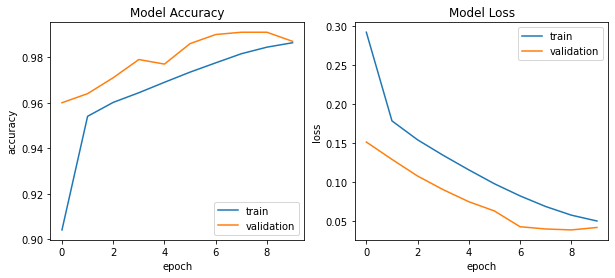

In [20]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history3)

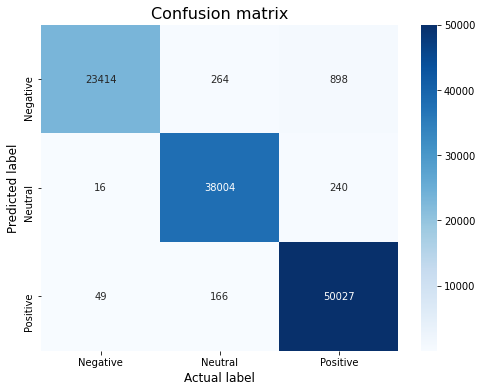

In [21]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model3, X_test, y_test)

In [22]:
# Save the model architecture & the weights
model3.save('sentimentModel.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')